## Deep Learning Study
#### Week 3: MNIST 분류 모델 학습
![image](https://user-images.githubusercontent.com/44901828/228213023-6af17f20-0457-40a3-91c4-3f80bd64c1ed.png)
- Pytorch에서 제공하는 nn.Module 클래스를 활용하여 간단한 딥 러닝 모델을 설계하고, [MNIST data](https://ko.wikipedia.org/wiki/MNIST_%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%B2%A0%EC%9D%B4%EC%8A%A4)를 분류할 수 있도록 학습시켜 봅시다.
- MNIST 분류 문제를 잘 푸는 모델은 input으로 손으로 쓴 숫자 이미지 데이터를 받아 output으로 실제 숫자를 정확하게 예측하는 모델이라고 할 수 있습니다.

In [1]:
import random
import numpy as np
import torchvision

# 재현을 위해 seed 고정
random.seed(42)
np.random.seed(42)

# MNIST
train_dataset = torchvision.datasets.MNIST(root="./data", transform=torchvision.transforms.ToTensor(), train=True, download=True)
test_dataset = torchvision.datasets.MNIST(root="./data", transform=torchvision.transforms.ToTensor(), train=False, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



- 불러온 MNIST 데이터셋이 어떤 형태로 구성되어 있는지 확인해 보겠습니다.
- 각각의 데이터는 28x28 크기의 이미지와 숫자 라벨로 구성되어 있네요.

In [2]:
from torchvision.transforms.functional import to_pil_image

print("Total data:", len(train_dataset))
for i in range(5):
    image = train_dataset[i][0]
    label = train_dataset[i][1]
    print(f"\n[Image] {image.shape}")
    to_pil_image(image).show()
    print(f"[Label] {label}")

Total data: 60000

[Image] torch.Size([1, 28, 28])


[Label] 5

[Image] torch.Size([1, 28, 28])


[Label] 0

[Image] torch.Size([1, 28, 28])


[Label] 4

[Image] torch.Size([1, 28, 28])


[Label] 1

[Image] torch.Size([1, 28, 28])


[Label] 9


![image](https://user-images.githubusercontent.com/44901828/228216655-d792374d-a3f7-4de6-b0e9-efc106f55064.png)
- 이제 MNIST 데이터 분류를 학습할 모델을 정의해 보겠습니다.
- 이미지는 가로 28픽셀, 세로 28픽셀의 크기를 가지므로 input으로 길이 784(28*28)를 받아 output으로 10개의 라벨에 대한 확률을 출력할 수 있도록 네트워크를 구성했습니다.

In [3]:
import torch
from torch import nn

model = nn.Sequential(
    nn.Linear(784, 128),
    nn.ReLU(),
    #nn.Linear(128, 64),
    #nn.ReLU(),
    nn.Linear(128, 10)
)

![image](https://user-images.githubusercontent.com/44901828/228437940-59595fa6-8046-45f0-9b2f-7b35df470702.png)
- 분류 문제에 일반적으로 사용되는 Cross Entropy Loss를 불러와 사용하겠습니다.
- 학습 과정에서 일정 단위의 데이터를 쉽게 불러와 사용할 수 있게 해주는 DataLoader를 사용하도록 하겠습니다.

In [4]:
loss_function = nn.CrossEntropyLoss()
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=1024, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1024, shuffle=False)

- 위에서 준비한 dataloader, 모델, loss를 이용하여 학습을 진행합니다.
- Forward/backward pass를 여러번 반복하며 loss가 작아지도록 gradient descent와 back propagation을 수행하는 과정은 torch를 이용하여 간단하게 수행 가능합니다.
- Optimizer는 [Adam](https://gaussian37.github.io/dl-dlai-Adam/)을 사용했습니다.
- 전체 데이터에 대해 학습이 진행된 횟수를 epoch라고 합니다. 1 epoch가 지날 때 마다 train data를 잘 분류하는지 확인하기 위해 test 함수를 호출해 줍니다.

In [5]:
def train(dataloader):
  num_epochs = 10
  loss_per_step = []

  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

  for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(dataloader):
        # 100, 1, 28, 28
        # 100, 724
        images = images.reshape(-1,28*28)
        
        # Forward pass
        outputs = model(images)

        # Loss 계산 및 저장
        loss = loss_function(outputs, labels)
        loss_per_step.append(loss.item())
        
        # Backward pass    
        # 계산된 gradient를 활용하여 파라미터 업데이트
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    acc = test(dataloader)    
    print(f"epoch {epoch+1}/{num_epochs}, train loss = {loss.item():.4f}, train accuracy: {acc:.2f}%")
      
  return loss_per_step

def test(dataloader):
  with torch.no_grad():
    n_correct = 0
    n_samples =0
    for images, labels in dataloader:
        images = images.reshape(-1,28*28)
        outputs = model(images)
        # value, index
        predictions = torch.argmax(outputs,dim=1)
        n_samples += labels.shape[0]
        n_correct += (predictions == labels).sum().item()
        
    acc = 100 * n_correct / n_samples
    return acc

- 학습이 진행되며 train loss는 감소하고, train accuracy는 증가하는 것을 볼 수 있습니다.
- 하지만 train data에 대해서 평가한 것만으로는 모델의 성능을 객관적으로 평가할 수 없습니다. 학습에 사용되지 않은 test 데이터를 사용해서 모델의 분류 성능을 평가해보도록 하겠습니다.

epoch 1/10, train loss = 0.4202, train accuracy: 88.54%
epoch 2/10, train loss = 0.2965, train accuracy: 91.30%
epoch 3/10, train loss = 0.2843, train accuracy: 92.72%
epoch 4/10, train loss = 0.2150, train accuracy: 93.65%
epoch 5/10, train loss = 0.2126, train accuracy: 94.34%
epoch 6/10, train loss = 0.1734, train accuracy: 94.90%
epoch 7/10, train loss = 0.1688, train accuracy: 95.35%
epoch 8/10, train loss = 0.1720, train accuracy: 95.68%
epoch 9/10, train loss = 0.1512, train accuracy: 96.08%
epoch 10/10, train loss = 0.1625, train accuracy: 96.42%


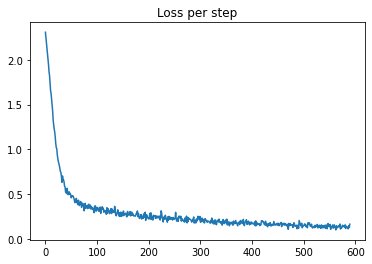

In [6]:
from matplotlib import pyplot as plt

loss_per_step = train(train_loader)

plt.plot(loss_per_step)
plt.title("Loss per step")
plt.show()

- Test accuracy가 높게 나오긴 했지만, train accuracy에는 미치지 못하는것을 알 수 있습니다.
- 모델이 test data에 대해 overfit되기 매우 쉽기 때문에, 모델을 학습한 다음에는 학습에 관여되지 않은 데이터로 평가하는 것이 매우 중요합니다.

In [7]:
train_acc = test(train_loader)
test_acc = test(test_loader)

print(f"Train accuracy: {train_acc:.2f}%")
print(f"Test accuracy: {test_acc:.2f}%")

Train accuracy: 96.42%
Test accuracy: 95.84%


- Test dataset에 포함된 데이터 몇개를 가져와서 모델에 입력해본 결과를 softmax 함수에 적용시켜 각각의 라벨에 대한 확률값을 표현해 보겠습니다.
- 정답 라벨의 확률이 가장 높고, 나머지 라벨에 대한 확률은 매우 낮게 출력되도록 학습된 것을 볼 수 있습니다.


[Image]

[Label] 0


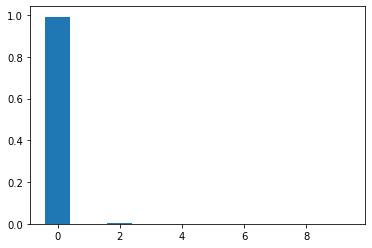


[Image]

[Label] 6


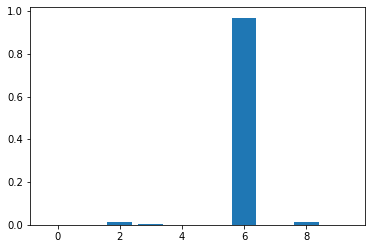


[Image]

[Label] 9


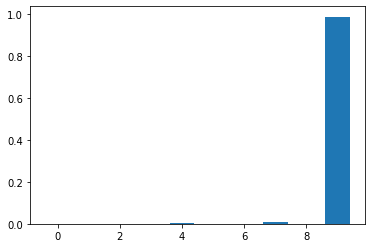


[Image]

[Label] 0


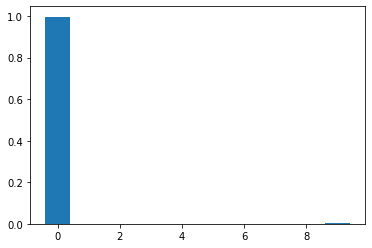


[Image]

[Label] 1


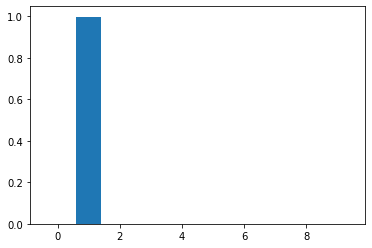

In [25]:
softmax = nn.Softmax(dim=1)
for i in range(0, 5):
  image = test_dataset[i][0]
  label = test_dataset[i][1]
  print(f"\n[Image]", end='')
  to_pil_image(image).show()
  print(f"[Label] {label}")

  model_output = model(image.reshape(-1, 28*28))
  pred_prob = softmax(model_output).detach().numpy()
  plt.bar(x=[i for i in range(10)], height=pred_prob[0])
  plt.show()